# ** Описание **

In [109]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import numpy as np

from collections import namedtuple
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

In [6]:
# import os

# folder_name= 'content_several'

# def get_doc_names(path):
#     _, _, filenames = next(os.walk(path))
#     return filenames
empty_titles = 0
empty_anchors = 0
def extract_doc_info(doc_name):
    global empty_titles
    global empty_anchors
    empty_titles = 0
    from bs4 import BeautifulSoup
#     global folder_name
#     full_doc_name = os.path.join(folder_name, doc_name)
    doc_info = {
#         'doc_id': int(doc_name.replace('.dat', '')),
        'title': "", 
        'description': "",
#         'og:site_name': None,
#         'url': None,
        'keywords': "",
        'anchors': "",
    }

#     with open(full_doc_name, 'r') as doc:
    doc = doc_name
#     url = ""
#     doc_info['url'] = url
    soup = BeautifulSoup(doc, 'html.parser')
    tit = soup.find('title')
    if tit and tit.contents:
            doc_info['title'] = tit.contents[0]
    else:
        empty_titles += 1
        
    anch = soup.find_all('a')
    if anch:
        doc_info['anchors'] = anch
    else:
        empty_anchors += 1 
    metas = soup.find_all('meta')
    for meta in metas:
#         if meta.get("property", None) == "og:site_name":
#             doc_info['og:site_name'] = meta.get("content", None)
#         elif meta.get("property", None) == "og:type":
#             doc_info['og:type'] = meta.get("content", None)
#         elif meta.get("property", None) == "og:locale":
#             doc_info['og:locale'] = meta.get("content", None)
#         elif meta.get("property", None) == "og:image":
#             doc_info['og:image'] = meta.get("content", None)
#         elif meta.get("property", None) == "og:video":
#             doc_info['og:video'] = meta.get("content", None)
        if meta.get("name", None) == "description":
            doc_info['description'] = meta.get("content", None)
        elif meta.get("name", None) == "keywords":
            doc_info['keywords'] = meta.get("content", None)
    return doc_info

# doc_names = get_doc_names(folder_name)
# doc_names = ['10017.dat']
# result = list(map(extract_doc_info, doc_names[:20]))

# df = pd.DataFrame(result)
# df.sort_values(by=['doc_id'], inplace=True)

#### Выбираем какой метод для конвертации html в текст будет основным

In [7]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [8]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [9]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [10]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [11]:
def calc_features(url, html_data):
    words = list(html2word(html_data))
    words_num = len(words)
    
    avg_word_len = sum(map(len, words)) / words_num
    
    title = extract_doc_info(html_data)['title']
    title_words_num = len(title.split())   
    
    anchor_list = extract_doc_info(html_data)['anchors']
    norm_anchor_list = [anchor.contents[0] if anchor.contents else "" for anchor in anchor_list]
#     k = [str for anch in norm_anchor_list]
    anchors = []
    for anch in norm_anchor_list:
        if anch:
            anchors.append(anch)
        else:
            anchors.append("")
            
    anchor_num = len(anchors)
    anchor_words_len = sum(len(i) for i in anchors)
    
    compression_level = len(zlib.compress(html_data)) / len(html_data)
                            
    return [len(words), avg_word_len, title_words_num, anchor_num, compression_level, anchor_words_len]
#     return anchor_words

In [12]:
# def calc_anchor_features(url, html_data):
#     anchor_list = extract_doc_info(html_data)['anchors']
#     norm_anchor_list = [anchor.contents[0] if anchor.contents else "" for anchor in anchor_list]
    
#     anchor_words_num = sum((len(anch.split()) for anch in norm_anchor_list))
    
#     return anchor_words_num

In [13]:
# result = list(map(extract_doc_info, doc_names[:20]))

# df = pd.DataFrame(result)
# df.sort_values(by=['doc_id'], inplace=True)

In [14]:
test_html_data = '''
<html>
<title> Заголовок <a>Ololo</a> </title>
спам 1 2 3 <a> anchor link text </a>
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print test_features

[9, 3.888888888888889, 1, 2, 0.9433962264150944, 23]


In [21]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 8

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in xrange(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [16]:
%%time

TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab.csv.gz'
# TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))

01:56:39 INFO:Complete items 00000 in worker_id 0
01:56:39 INFO:Complete items 00000 in worker_id 1
01:56:39 INFO:Complete items 00000 in worker_id 2
01:56:39 INFO:Complete items 00000 in worker_id 3
01:56:39 INFO:Complete items 00000 in worker_id 4
01:56:39 INFO:Complete items 00000 in worker_id 6
01:56:39 INFO:Complete items 00000 in worker_id 5
01:56:39 INFO:Complete items 00000 in worker_id 8
01:56:39 INFO:Complete items 00000 in worker_id 7
01:56:39 INFO:Complete items 00000 in worker_id 10
01:56:39 INFO:Complete items 00000 in worker_id 11
01:56:39 INFO:Complete items 00000 in worker_id 13
01:56:39 INFO:Complete items 00000 in worker_id 14
01:56:39 INFO:Complete items 00000 in worker_id 9
01:56:39 INFO:Complete items 00000 in worker_id 12
01:56:39 INFO:Complete items 00000 in worker_id 15
01:58:23 INFO:Complete items 01000 in worker_id 8
01:58:29 INFO:Complete items 01000 in worker_id 5
01:58:39 INFO:Complete items 01000 in worker_id 14
01:58:41 INFO:Complete items 01000 in worke

CPU times: user 471 ms, sys: 151 ms, total: 622 ms
Wall time: 18min 46s


In [17]:
train_copy = train_docs[:]

In [22]:
%%time

TEST_DATA_FILE  = 'kaggle/kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = list(load_csv_multiprocess(TEST_DATA_FILE, calc_features))

02:20:36 INFO:Complete items 00000 in worker_id 0
02:20:36 INFO:Complete items 00000 in worker_id 1
02:20:36 INFO:Complete items 00000 in worker_id 2
02:20:36 INFO:Complete items 00000 in worker_id 3
02:20:36 INFO:Complete items 00000 in worker_id 4
02:20:36 INFO:Complete items 00000 in worker_id 6
02:20:36 INFO:Complete items 00000 in worker_id 7
02:20:36 INFO:Complete items 00000 in worker_id 5
02:22:35 INFO:Complete items 01000 in worker_id 6
02:22:38 INFO:Complete items 01000 in worker_id 2
02:22:52 INFO:Complete items 01000 in worker_id 1
02:23:09 INFO:Complete items 01000 in worker_id 4
02:23:37 INFO:Complete items 01000 in worker_id 5
02:24:03 INFO:Complete items 01000 in worker_id 3
02:24:29 INFO:Complete items 01000 in worker_id 7
02:25:01 INFO:Complete items 02000 in worker_id 2
02:25:20 INFO:Complete items 02000 in worker_id 6
02:25:58 INFO:Complete items 02000 in worker_id 5
02:26:03 INFO:Complete items 02000 in worker_id 1
02:26:16 INFO:Complete items 02000 in worker_id 4


CPU times: user 969 ms, sys: 276 ms, total: 1.25 s
Wall time: 47min 32s


In [18]:
len(train_copy)

7044

In [23]:
test_copy = test_docs[:]

In [24]:
len(test_docs)

16039

/home/waffpad/anaconda3/envs/antispam/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


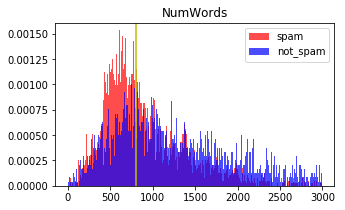

In [25]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(1, 3000, 10)
plt.figure(figsize=(5,3))
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.axvline(800,c='y')
plt.title('NumWords')
plt.legend()
plt.show()

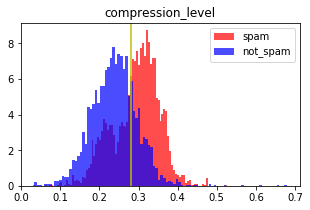

In [26]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = 100
plt.figure(figsize=(5,3))
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.axvline(0.28,c='y')
plt.title('compression_level')
plt.legend()
plt.show()

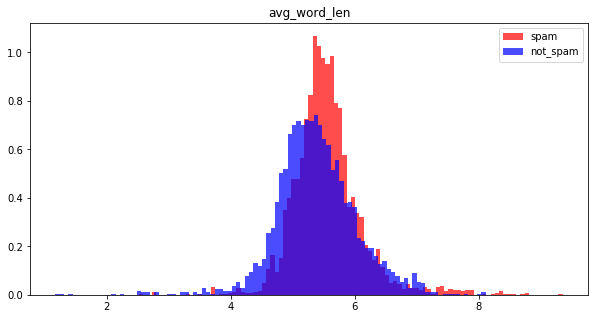

In [27]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.figure(figsize=(10,5))
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
# plt.axvline(0.28,c='y')
plt.title('avg_word_len')
plt.legend()
plt.show()

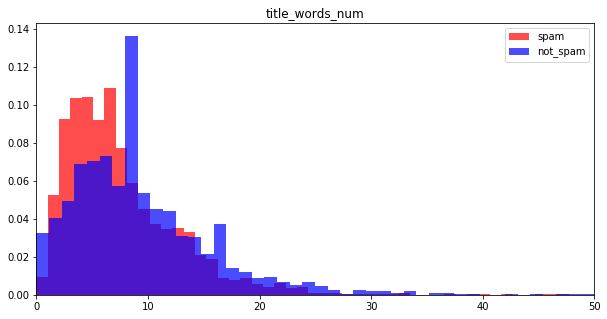

In [28]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = 200
plt.figure(figsize=(10,5))
plt.xlim(0,50)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
# plt.axvline(0.28,c='y')
plt.title('title_words_num')
plt.legend()
plt.show()

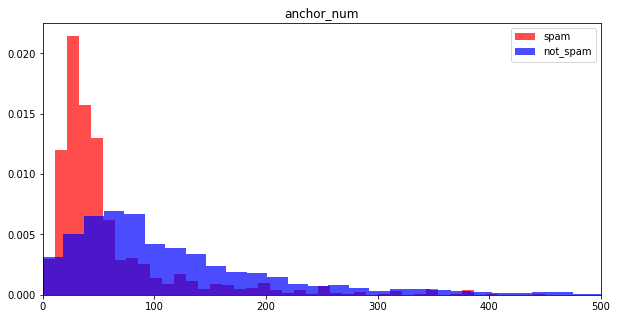

In [29]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = 200
plt.figure(figsize=(10,5))
plt.xlim(0,500)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
# plt.axvline(0.28,c='y')
plt.title('anchor_num')
plt.legend()
plt.show()

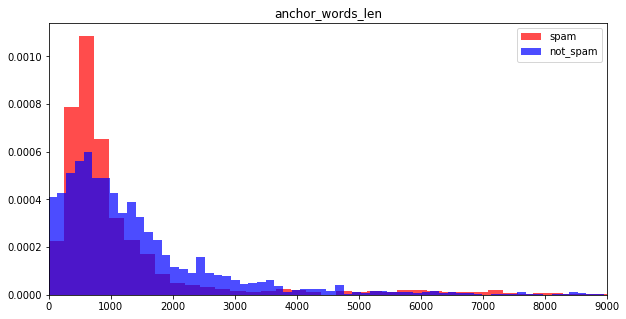

In [30]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = 300
plt.figure(figsize=(10,5))
plt.xlim(0,9000)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
# plt.axvline(0.28,c='y')
plt.title('anchor_words_len')
plt.legend()
plt.show()

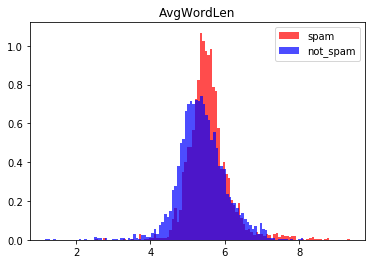

In [31]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

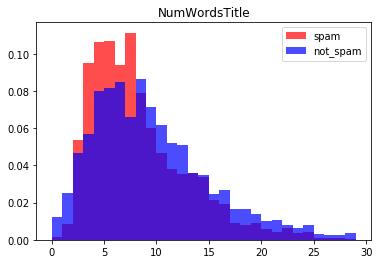

In [32]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

In [33]:
#Добавить графики для остальных фичей

** Классификатор: **
Нужно реализовать

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV

In [120]:
clf = RandomForestClassifier(max_depth=2, random_state=0,
                             n_estimators=100,  n_jobs=-1) 
# clf = RandomForestClassifier(random_state=0, n_jobs=-1) 

In [149]:
X, y = [], []
for doc in train_docs:
    X.append(doc.features)
    y.append(1 if doc.is_spam else 0)
X, y = np.array(X), np.array(y)
X.shape, y.shape

((7044, 6), (7044,))

In [137]:
(test_docs[0].is_spam)

True

In [138]:
train_docs[100]

DocItem(doc_id=-9108377762069095307, is_spam=False, url='http://vrtp.ru/index.php?showtopic=7944', features=[3116, 5.059050064184852, 4, 263, 0.18146690148140474, 2234])

In [156]:
X_test = []
for doc in test_docs:
    X_test.append(doc.features)
X_test = np.array(X_test)
X_test.shape

(16039, 6)

In [151]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [169]:
%time random_search.fit(X_tr, y_tr)

KeyboardInterrupt: 

In [144]:
random_search.best_score_

0.7120997002681811

In [145]:
f1_score(y_pred=random_search.predict(X_te), y_true=y_te, average='macro')

0.7005976353091066

In [153]:
from sklearn.tree import DecisionTreeClassifier

In [154]:
clf = DecisionTreeClassifier(min_samples_split=2)
%time clf.fit(X_tr, y_tr)

CPU times: user 35.1 ms, sys: 0 ns, total: 35.1 ms
Wall time: 34.3 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [155]:
f1_score(y_pred=clf.predict(X_te), y_true=y_te, average='macro')

0.8108747044917257

In [73]:
%%time

param_grid = {
    "max_depth": range(2, 10),
    "min_samples_split": range(2, 10),
    "criterion": ["gini", "entropy"],
    "n_estimators": range(2, 100, 5)}

model = RandomForestClassifier()
random_search = RandomizedSearchCV(model, param_grid, cv=5, n_iter=400, n_jobs=-1)
random_search.fit(X, y)
random_search.best_params_

CPU times: user 9.62 s, sys: 1.03 s, total: 10.6 s
Wall time: 2min 57s


In [74]:
random_search.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_split': 7,
 'n_estimators': 57}

In [76]:
my_pred = random_search.predict(X_test)

In [158]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [159]:
print(clf.feature_importances_)

[0.15065494 0.10207765 0.05432986 0.30724825 0.20211579 0.1835735 ]


In [160]:
my_pred = clf.predict(X_test)

In [161]:
my_pred.shape

(16039,)

In [167]:
from catboost import CatBoostClassifier

In [168]:
model = CatBoostClassifier(iterations=400,
                           depth=10,
                           learning_rate=0.5,
                           loss_function='Logloss',
                           verbose=False
                          
                          )

In [171]:
def find_best(train_X, train_y):

    max_f1_score = -1 
    X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.1, stratify=train_y)
    
    for lr in range(4, 6, 1):
        for dth in range(5, 8, 1):
            for epochs in range(100, 1000, 100):
                
                model = CatBoostClassifier(iterations=epochs,
                                           depth=dth,
                                           learning_rate=1. * lr / 10.,
                                           loss_function='Logloss',
                                           verbose=False
                                          
                                          )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                score = f1_score(y_test, y_pred)
                
                if (score > max_f1_score):
                    max_f1_score = score
                    best_model = model
                    print("Score: "+str(max_f1_score))
                    print("Model Parameters: LR: "+str(lr)+"  Dth: "+str(dth)+" ITERS: "+str(epochs)+"\n")
        
        print("\nNew Learning Rate: "+ str(1. * lr / 10.)+"\n")
                
    return best_model

In [172]:
best_model = find_best(X, y)

Score: 0.8757687576875769
Model Parameters: LR: 4  Dth: 5 ITERS: 100

Score: 0.8848484848484849
Model Parameters: LR: 4  Dth: 5 ITERS: 200

Score: 0.8935128518971848
Model Parameters: LR: 4  Dth: 6 ITERS: 200

Score: 0.8950542822677926
Model Parameters: LR: 4  Dth: 7 ITERS: 200

Score: 0.896719319562576
Model Parameters: LR: 4  Dth: 7 ITERS: 900


New Learning Rate: 0.4

Score: 0.8968058968058967
Model Parameters: LR: 5  Dth: 6 ITERS: 200

Score: 0.9006134969325154
Model Parameters: LR: 5  Dth: 6 ITERS: 300

Score: 0.9037758830694276
Model Parameters: LR: 5  Dth: 7 ITERS: 500

Score: 0.9075425790754258
Model Parameters: LR: 5  Dth: 7 ITERS: 600


New Learning Rate: 0.5



In [173]:
def make_predict(model, test_X, test_docs):
    
    preds = model.predict(test_X)
    prediction = []
    for p in preds:
        prediction.append(int(p))
        
    with open('my_submission.csv' , 'wb') as fout:
        writer = csv.writer(fout)
        writer.writerow(['Id','Prediction'])
        for i in range(len(test_docs)):
            writer.writerow([test_docs[i].doc_id, prediction[i]])
        
    pass

In [174]:
make_predict(best_model, X_test, test_docs)

In [79]:
# with open('my_submission.csv' , 'wb') as fout:
#     writer = csv.writer(fout)
#     writer.writerow(['Id','Prediction'])
#     for i,item in enumerate(test_docs):
#         prediction =  my_pred[i]
#         writer.writerow([i, prediction])

In [163]:
res = [['Id', 'Prediction']]
with open('my_submission_0.56.csv') as csvfile: 
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for i,row in enumerate(spamreader):
        row = list(map(int, row))
        res.append([row[0], my_pred[i]])

In [164]:
with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
#     writer.writerow(['Id','Prediction'])
    for row in res:
#         prediction =  my_pred[i]
        writer.writerow(row)

In [566]:
class Classifier:
    
    def __init__(self):
        pass

    def predict(self, doc):        
        return doc.features[4]                     
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):                
        for doc_num, doc in enumerate(docs):                            
            #TODO вставить код обучения
            trace(doc_num)
        trace(doc_num, 1)

In [567]:
classifier = Classifier()
classifier.train(train_docs)

01:04:24 INFO:Complete items 00000
01:04:24 INFO:Complete items 01000
01:04:24 INFO:Complete items 02000
01:04:24 INFO:Complete items 03000
01:04:24 INFO:Complete items 04000
01:04:24 INFO:Complete items 05000
01:04:24 INFO:Complete items 06000
01:04:24 INFO:Complete items 07000
01:04:24 INFO:Complete items 07043


In [569]:
#Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_features))

0.9433962264150944

** Рисуем графики **

01:04:32 INFO:Complete items 00000
01:04:32 INFO:Complete items 01000
01:04:32 INFO:Complete items 02000
01:04:32 INFO:Complete items 03000
01:04:32 INFO:Complete items 04000
01:04:32 INFO:Complete items 05000
01:04:32 INFO:Complete items 06000
01:04:32 INFO:Complete items 07000


threshold 0
	class_prec 0.583333333333, class_recall 1.0, class_F1 0.736842105263
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.368421052632
threshold 100
	class_prec 0.0, class_recall 0.0, class_F1 0.0
	not_class_prec 0.416666666667, not_class_recall 1.0, not_class_F1 0.588235294118
		MacroF1Mesure 0.294117647059
threshold 200
	class_prec 0.0, class_recall 0.0, class_F1 0.0
	not_class_prec 0.416666666667, not_class_recall 1.0, not_class_F1 0.588235294118
		MacroF1Mesure 0.294117647059
threshold 300
	class_prec 0.0, class_recall 0.0, class_F1 0.0
	not_class_prec 0.416666666667, not_class_recall 1.0, not_class_F1 0.588235294118
		MacroF1Mesure 0.294117647059
threshold 400
	class_prec 0.0, class_recall 0.0, class_F1 0.0
	not_class_prec 0.416666666667, not_class_recall 1.0, not_class_F1 0.588235294118
		MacroF1Mesure 0.294117647059
threshold 500
	class_prec 0.0, class_recall 0.0, class_F1 0.0
	not_class_prec 0.416666666667, not_class_recall 1.0, not_class_F

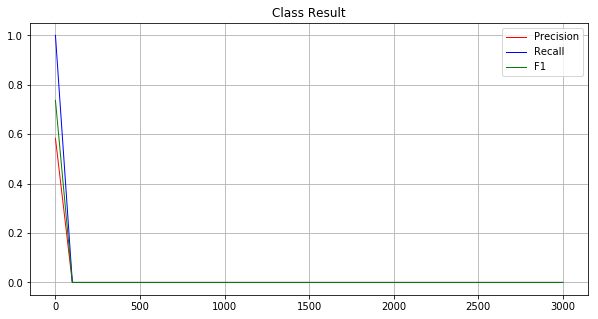

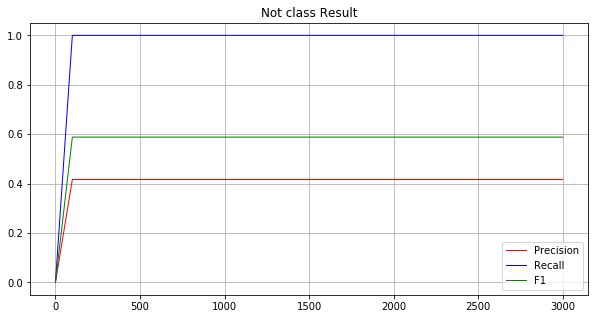

In [570]:
plot_results(train_docs, min_threshold=0, max_threshold=3000, step=100, trace=1)

In [86]:
%%time

TEST_DATA_FILE  = 'kaggle/kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = load_csv_multiprocess(TEST_DATA_FILE, calc_features)

threshold = 0.28

with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

15:23:01 INFO:Complete items 00000 in worker_id 0
15:23:01 INFO:Complete items 00000 in worker_id 1
15:23:01 INFO:Complete items 00000 in worker_id 2
15:23:01 INFO:Complete items 00000
15:23:01 INFO:Complete items 00000 in worker_id 3
15:23:06 INFO:Complete items 01000 in worker_id 2
15:23:07 INFO:Complete items 01000 in worker_id 1
15:23:07 INFO:Complete items 01000
15:23:09 INFO:Complete items 01000 in worker_id 3
15:23:10 INFO:Complete items 01000 in worker_id 0
15:23:12 INFO:Complete items 02000 in worker_id 2
15:23:12 INFO:Complete items 02000 in worker_id 1
15:23:15 INFO:Complete items 02000
15:23:17 INFO:Complete items 02000 in worker_id 0
15:23:17 INFO:Complete items 02000 in worker_id 3
15:23:19 INFO:Complete items 03000 in worker_id 2
15:23:19 INFO:Complete items 03000 in worker_id 1
15:23:21 INFO:Complete items 03000
15:23:23 INFO:Complete items 03000 in worker_id 3
15:23:24 INFO:Complete items 03000 in worker_id 0
15:23:24 INFO:Complete items 04000 in worker_id 2
15:23:25 I

CPU times: user 686 ms, sys: 167 ms, total: 853 ms
Wall time: 1min 45s
